In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats
import os


In [2]:
# Add tensorboard stuff
# %load_ext tensorboard
# import datetime

# !rm -rf ./logs/


In [3]:
#fix all seeds for random number generators
# Set seed value
seed_value = 9
import os
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# TODO need to add session thing for tensorflow

# Read Depth Camera

In [4]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#             gray_frame = frame/np.maximum(np.max(frame),255) keep as int8 for memory savings
            gray_frame = frame
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [5]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [6]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [7]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)

n_test = (1,2,24,30,31,32,33,35,1,3)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0

subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
        
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    train_dcamera_path = os.path.join(data_dir , 'depth_processed_'+subj[i]+'_test'+str(n_test[i])+'.avi')
    xtemp[i] = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize).astype('uint8')
    


In [8]:
tlen=0
for x in range(len(xtemp)):
    tlen+= xtemp[x].shape[0]
xrun_cum = 0
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]),dtype='uint8')
for i in range (len(xtemp)):
    xrun_n = len(xtemp[i])
    x_train[xrun_cum:xrun_cum+xrun_n,:,:,:] = xtemp[i][:xrun_n,:,:,:]
    xrun_cum += xrun_n

In [9]:
x_train.shape

(153421, 60, 80, 3)

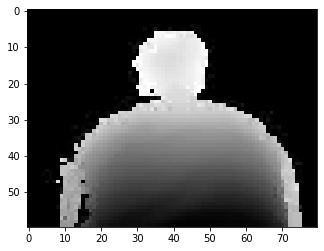

In [10]:
plt.imshow(x_train[153418])

In [11]:
print(x_train.shape)
del xtemp

(153421, 60, 80, 3)


# read fcss data

In [12]:

n_test = (1,2,24,30,31,32,33,35,1,3)
date = ('12_2_2020','12_11_2020','11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020','12_2_2020','12_11_2020')
subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
subjwgt = [61,61, 67, 67, 67, 67, 67, 67, 70, 70]
subjht = [180, 180, 174, 174, 174, 174, 174, 174, 170, 170]
xfcss_gt = {}
yrun = 0
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    fcss_data_dir = os.path.join(data_dir , 'fcss_processed_'+subj[i]+'_' + test_str + '_' + date[i] + '.txt')
    xfcss_gttemp = pd.read_csv(fcss_data_dir)/subjwgt[i]
    xfcss_gt[i]=xfcss_gttemp
#     xfcss_gt[i]['weight'] = subjwgt[i]# hacky but will work for now
#     xfcss_gt[i]['height'] = subjht[i]# hacky but will work for now
    if i==0:
        xfcss_train=xfcss_gttemp
    else:
        xfcss_train = pd.concat([xfcss_train,xfcss_gt[i]],axis=0)
del xfcss_gt

In [13]:
xfcss_train

,Fz bottom (kg),Fz left (kg),Fz right (kg),Fx left (kg),Fx right (kg),Fy (kg)
0,-0.828197,-0.189016,-0.198197,0.150164,0.196066,0.003934
1,-0.824918,-0.189836,-0.200328,0.150164,0.194918,0.003115
2,-0.822623,-0.191148,-0.202787,0.149836,0.194262,0.002623
3,-0.821148,-0.192787,-0.204590,0.150000,0.194918,0.002295
4,-0.821148,-0.194098,-0.206393,0.149836,0.196557,0.002295
...,...,...,...,...,...,...
23050,-0.710714,-0.272571,-0.248571,0.164429,0.182571,0.005857
23051,-0.711143,-0.269857,-0.248286,0.165571,0.178714,0.007000
23052,-0.710714,-0.266286,-0.248429,0.166143,0.174000,0.007714
23053,-0.710286,-0.263000,-0.248857,0.167143,0.169857,0.008000


# Read Output Data


In [14]:

n_test = (1,2,24,30,31,32,33,35,1,3)
date = ('12_2_2020','12_11_2020','11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020','12_2_2020','12_11_2020')
subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    qtm_file_data_dir = os.path.join(data_dir , 'qtm_processed_'+subj[i]+'_test' + str(n_test[i]) + '_' + date[i] + '.txt')
    y_gt[i] = read_output_data(qtm_file_data_dir,theta_interest).values

    

# tlen = len(y_gt[0])+len(y_gt[1])+len(y_gt[2])+len(y_gt[3])+len(y_gt[4])+len(y_gt[5])
# y_train = np.zeros((tlen,1))
# xrun = len(y_gt[0])
# y_train[:xrun] = y_gt[0][:xrun]
# xrun1 = xrun + len(y_gt[1])
# y_train[xrun:xrun1]=y_gt[1][:xrun1-xrun]
# xrun2 = xrun1 + len(y_gt[2])
# y_train[xrun1:xrun2] = y_gt[2][:xrun2-xrun1]
# xrun3 = xrun2 + len(y_gt[3])
# y_train[xrun2:xrun3] = y_gt[3][:xrun3-xrun2]
# xrun4 = xrun3 + len(y_gt[4])
# y_train[xrun3:xrun4] = y_gt[4][:xrun4-xrun3]
# xrun5 = xrun4 + len(y_gt[5])
# y_train[xrun4:xrun5] = y_gt[5][:xrun5-xrun4]
# del y_gt

In [15]:
tlen=0
for x in range(len(y_gt)):
    tlen+= y_gt[x].shape[0]
yrun_cum = 0
y_train = np.zeros((tlen,1))
for i in range (len(y_gt)):
    yrun_n = len(y_gt[i])
    y_train[yrun_cum:yrun_cum+yrun_n] = y_gt[i][:]
    yrun_cum += yrun_n

In [16]:
# Saturate output
def saturate(theta, min_val, max_val):
    for i in range(len(theta)):
        if theta[i] < min_val:
            theta[i] = min_val
            continue
        if theta[i] > max_val:
            theta[i] = max_val
            continue
    return theta
            
min_val = -50
max_val = 50
    
y_train = saturate(y_train, min_val, max_val)

In [17]:
print(x_train.shape)
print(xfcss_train.shape)
print(y_train.shape)

(153421, 60, 80, 3)
(153421, 6)
(153421, 1)


In [18]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [19]:
Trainset = x_train[rannums,:]
Trainset2 = xfcss_train.values[rannums,:]
Testset = x_train[test_set,:]
Testset2 = xfcss_train.values[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [20]:
sc_X2 = StandardScaler()
sc_y = StandardScaler()

In [21]:
Xtrainz = Trainset
Xtrainz2 = Trainset2
ytrainz = Trainy
X = Xtrainz
X2 = sc_X2.fit_transform(Xtrainz2)
y = sc_y.fit_transform(ytrainz)

In [22]:
#make validation data available to model.fit
Xvalid = Testset
Xvalid2 = sc_X2.transform(Testset2)
y_valid = Testy
y_valid = sc_y.transform(y_valid)


In [23]:
# clear up some used variables
del Trainset
del Trainset2
del Testset
del Testset2


# Regress using Neural Network

In [24]:
x_train.shape

(153421, 60, 80, 3)

In [25]:
# Create Neural Netowrk

from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, concatenate, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute, Flatten
from tensorflow.keras.models import Model
dropout_rate = 0.2

model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_start2 = Input(shape=(xfcss_train.shape[1],))
model_cnn = model_start
model_perc = model_start2

model_cnn = Conv2D(filters=8, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=8, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(32)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(32)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Flatten()(model_cnn)
# model_perc = Flatten()(model_perc)
# model_cnn = Activation('relu')(model_cnn)

model_cnn = Dense(100)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_comb = concatenate([model_cnn,model_perc],axis=-1)

model_comb = Dense(256)(model_comb)
# model_comb = BatchNormalization()(model_comb)
model_comb = Activation('relu')(model_comb)
model_comb = Dropout(dropout_rate)(model_comb)

output = Dense(1)(model_comb)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=[model_start,model_start2],outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50,restore_best_weights=True) #Moving to 1000 patience.


In [26]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 80, 8)    224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 80, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 60, 80, 8)    0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [27]:
print(tf.__version__)

2.3.1


In [28]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
from tensorflow.keras import layers
with tf.device('/device:CPU:0'):
    data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomZoom(height_factor = (-0.2,0.2),
                                               width_factor = (-0.2,0.2), 
                                               fill_mode = 'constant'),
        layers.experimental.preprocessing.RandomRotation(0.05)], 
        name='data_augmentation')

# create data generator
def get_generator_cyclic(features1, features2, labels, batch_size=256):
    while True:
        for n in range(int(len(features1)/batch_size)):
            X = features1[n*batch_size: (n+1)*batch_size]
            with tf.device('/device:CPU:0'): #to prevent hogging limited gpu space
                augmented_images = data_augmentation(X)
                Xnew =  tf.cast(augmented_images,tf.float64)/255
            yield [Xnew, features2[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size]]
        permuted = np.random.permutation(len(features1))
        features1 = features1[permuted]
        features2 = features2[permuted]
        labels = labels[permuted]


In [49]:
def scheduler(epoch, lr):
    if e < 200: #very hacky
        return 0.001
    else:
        if e%10==0:
            return lr * 0.9
        else:
            return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [31]:
from datetime import datetime
batch_size = 32
batch_mult = 30
readin = int(batch_size*batch_mult)
epochs = int(300)
training_generator = get_generator_cyclic(X,X2,y,readin)
# test_generator = get_generator_cyclic(Xvalid,Xvalid2,y_valid,readin)
for e in range(epochs):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print('Epoch', e,'Time: ', current_time)
    batches = 0
    while batches<= len(X)/readin:
        Xtrain_1, Xtrain_2, ytrain_1 = next(training_generator)
#         Xtest_1, Xtest_2, ytest_1 =next(test_generator)
#         model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],validation_data = ([Xtest_1,Xtest_2], ytest_1),batch_size=batch_size,verbose = 0)
        model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],batch_size=batch_size,verbose = 0)
        batches += 1
        

Epoch 0 Time:  21:04:35
Epoch 1 Time:  21:05:52
Epoch 2 Time:  21:07:06
Epoch 3 Time:  21:08:20
Epoch 4 Time:  21:09:33
Epoch 5 Time:  21:10:47
Epoch 6 Time:  21:12:01
Epoch 7 Time:  21:13:14
Epoch 8 Time:  21:14:28
Epoch 9 Time:  21:15:41
Epoch 10 Time:  21:16:55
Epoch 11 Time:  21:18:08
Epoch 12 Time:  21:19:22
Epoch 13 Time:  21:20:35
Epoch 14 Time:  21:21:48
Epoch 15 Time:  21:23:02
Epoch 16 Time:  21:24:15
Epoch 17 Time:  21:25:29
Epoch 18 Time:  21:26:42
Epoch 19 Time:  21:27:56
Epoch 20 Time:  21:29:09
Epoch 21 Time:  21:30:23
Epoch 22 Time:  21:31:36
Epoch 23 Time:  21:32:49
Epoch 24 Time:  21:34:02
Epoch 25 Time:  21:35:16
Epoch 26 Time:  21:36:29
Epoch 27 Time:  21:37:43
Epoch 28 Time:  21:38:56
Epoch 29 Time:  21:40:09
Epoch 30 Time:  21:41:23
Epoch 31 Time:  21:42:36
Epoch 32 Time:  21:43:50
Epoch 33 Time:  21:45:03
Epoch 34 Time:  21:46:16
Epoch 35 Time:  21:47:29
Epoch 36 Time:  21:48:43
Epoch 37 Time:  21:49:56
Epoch 38 Time:  21:51:09
Epoch 39 Time:  21:52:23
Epoch 40 T

In [52]:
# continue training
training_generator = get_generator_cyclic(X,X2,y,readin)
for e in range(epochs):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print('Epoch', e,'Time: ', current_time)
    batches = 0
    while batches<= len(X)/readin:
        Xtrain_1, Xtrain_2, ytrain_1 = next(training_generator)
#         Xtest_1, Xtest_2, ytest_1 =next(test_generator)
#         model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],validation_data = ([Xtest_1,Xtest_2], ytest_1),batch_size=batch_size,verbose = 0)
        model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],batch_size=batch_size,verbose = 0)
        batches += 1

Epoch 0 Time:  03:29:09
Epoch 1 Time:  03:30:23
Epoch 2 Time:  03:31:40
Epoch 3 Time:  03:32:52
Epoch 4 Time:  03:34:04
Epoch 5 Time:  03:35:21
Epoch 6 Time:  03:36:33
Epoch 7 Time:  03:37:45
Epoch 8 Time:  03:38:57
Epoch 9 Time:  03:40:08
Epoch 10 Time:  03:41:20
Epoch 11 Time:  03:42:31
Epoch 12 Time:  03:43:43
Epoch 13 Time:  03:44:54
Epoch 14 Time:  03:46:06
Epoch 15 Time:  03:47:18
Epoch 16 Time:  03:48:29
Epoch 17 Time:  03:49:41
Epoch 18 Time:  03:50:53
Epoch 19 Time:  03:52:04
Epoch 20 Time:  03:53:15
Epoch 21 Time:  03:54:27
Epoch 22 Time:  03:55:39
Epoch 23 Time:  03:56:50
Epoch 24 Time:  03:58:02
Epoch 25 Time:  03:59:14
Epoch 26 Time:  04:00:25
Epoch 27 Time:  04:01:37
Epoch 28 Time:  04:02:48
Epoch 29 Time:  04:04:00
Epoch 30 Time:  04:05:11
Epoch 31 Time:  04:06:23
Epoch 32 Time:  04:07:35
Epoch 33 Time:  04:08:46
Epoch 34 Time:  04:09:57
Epoch 35 Time:  04:11:09
Epoch 36 Time:  04:12:21
Epoch 37 Time:  04:13:32
Epoch 38 Time:  04:14:44
Epoch 39 Time:  04:15:56
Epoch 40 T

In [ ]:
#%tensorboard --logdir logs/fit

In [ ]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

In [ ]:

# sanity check with 80% data
Xtrainz = Trainset/255.
Xtrainz2 = sc_X2.transform(Trainset2)
y_pred = model.predict([Xtrainz,Xtrainz2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

In [47]:
# cheap way to check mse for test set
losssc, msesc, maesc = model.evaluate([Xvalid/255.,Xvalid2],y_valid)
mae = maesc*(sc_y.var_)**0.5
print('Mean absolute error is: {:4.2f}'.format(mae[0]))

959/959 [==============================] - 5s 5ms/step - loss: 0.1930 - mse: 0.1452 - mae: 0.1930
Mean absolute error is: 2.26


In [53]:
losssc, msesc, maesc = model.evaluate([Xvalid/255.,Xvalid2],y_valid)
mae = maesc*(sc_y.var_)**0.5
print('Mean absolute error is: {:4.2f}'.format(mae[0]))

959/959 [==============================] - 5s 5ms/step - loss: 0.1790 - mse: 0.1331 - mae: 0.1790
Mean absolute error is: 2.10


In [ ]:
# Redo test set
Xtest = Testset/255.
Xtest2 = sc_X2.transform(Testset2)
y_pred = model.predict([Xtest,Xtest2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [54]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodelparam_cnn3v25_r2_pb.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
#     modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
#         pickle.dump([randata,sc_y,sc_X2,modelhistory], file)
          pickle.dump([randata,sc_y,sc_X2], file)
        
#     !mkdir -p saved_model
#     model.save('saved_model/cnn3v22')

In [55]:
model.save('saved_model/cnn3v24_r2')

INFO:tensorflow:Assets written to: saved_model/cnn3v24_r2\assets
